In [5]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from xgboost import XGBRegressor

In [6]:
# Ucitavanje podataka
train_df_previous_lives = pd.read_csv('previous_lives_training_data.csv')
train_df_registration = pd.read_csv('registration_data_training.csv')

In [7]:
# print('Info: ', train_df_previous_lives.info())
# print(train_df_previous_lives.describe())

In [8]:
# print('Info: ', train_df_registration.info())
# print(train_df_registration.describe())

In [9]:
# Ucitavanje test podataka
test_df_registration = pd.read_csv('registration_data_test.csv')
test_df_previous_lives = pd.read_csv('previous_lives_test_data.csv')

In [10]:
# print('Info: ', test_df_registration.info())
# print(test_df_registration.describe())

In [11]:
# print('Info: ', test_df_previous_lives.info())
# print(test_df_previous_lives.describe())

In [12]:
# Agregacija podataka za korisnike sa vise predhodnih zivota -> TRENING SET
train_df_previous_lives_agg = train_df_previous_lives.groupby('user_id').agg(
    registration_date=('registration_date', 'first'),
    registration_season_day = ('registration_season_day', 'first'),
    is_payer_lifetime=('is_payer_lifetime', 'max'),
    days_active_lifetime=('days_active_lifetime', 'sum'),
    transaction_count_iap_lifetime=('transaction_count_iap_lifetime', 'sum'),
    is_rewarded_video_watcher_lifetime=('is_rewarded_video_watcher_lifetime', 'max'),
    registration_country=('registration_country', 'first'),
    registration_channel_detailed=('registration_channel_detailed', 'first'),
    registration_store=('registration_store', 'first'),
    registration_platform_specific=('registration_platform_specific', 'first')
).reset_index()

In [13]:
# Spajanje podataka na osnovu 'user_id' -> TRENING SET
df_train = pd.merge(train_df_registration, train_df_previous_lives_agg, on='user_id', how='left')

df_train.describe()

,user_id,registration_season_day_x,session_count,playtime,number_of_devices_used,total_match_played_count,total_match_won_count,total_match_watched_count,transaction_count_iap,transaction_count_rewarded_video,...,morale_spent,money_stash,avg_stars_top_11_players,avg_stars_top_3_players,avg_age_top_11_players,training_count,days_active_first_28_days_after_registration,registration_season_day_y,days_active_lifetime,transaction_count_iap_lifetime
count,50000.000000,50000.000000,50000.000000,5.000000e+04,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,5.000000e+04,50000.000000,50000.000000,49997.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000
mean,109844.239100,13.613980,2.254440,1.938928e+06,1.00320,1.013760,0.709820,0.358140,0.020400,1.403980,...,4.944480,4.204060e+08,4.992721,5.672375,22.771246,3.254040,7.44444,14.425520,42.531320,1.061640
std,63219.003941,8.048579,2.107337,2.452801e+06,0.11606,1.624298,1.223685,0.951953,0.252161,4.470676,...,13.810084,4.463889e+08,0.509699,0.575280,1.061690,11.081785,9.69814,8.088763,66.123853,6.763369
min,5.000000,1.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-1.770021e+08,0.000000,0.000000,20.000000,0.000000,0.00000,1.000000,1.000000,0.000000
25%,55070.750000,7.000000,1.000000,3.527005e+05,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,3.993034e+07,4.668524,5.296833,22.000000,0.000000,0.00000,8.000000,4.000000,0.000000
50%,109571.000000,13.000000,2.000000,1.151846e+06,1.00000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.780944e+08,5.029946,5.734822,23.000000,1.000000,2.00000,14.000000,17.000000,0.000000
75%,165091.750000,21.000000,3.000000,2.609020e+06,1.00000,1.000000,1.000000,0.000000,0.000000,1.000000,...,6.000000,8.280786e+08,5.352279,6.070400,23.000000,4.000000,13.00000,21.000000,51.000000,0.000000
max,218956.000000,28.000000,52.000000,5.817359e+07,4.00000,29.000000,17.000000,19.000000,15.000000,58.000000,...,361.000000,2.224926e+09,7.382315,8.214578,28.000000,516.000000,28.00000,28.000000,650.000000,335.000000


In [14]:
# df_train.info()

In [15]:
df_train.head()

,user_id,registration_time_utc,registration_platform_specific_x,registration_country_x,registration_store_x,registration_season_day_x,registration_channel_detailed_x,registration_device_type,registration_device_manufacturer,session_count,...,registration_date,registration_season_day_y,is_payer_lifetime,days_active_lifetime,transaction_count_iap_lifetime,is_rewarded_video_watcher_lifetime,registration_country_y,registration_channel_detailed_y,registration_store_y,registration_platform_specific_y
0,5,2024-05-25 01:26:48.000,iOS Phone,France,AppStore,7,Organic,Phone,Apple,1,...,2022-04-21,26,False,19,0,True,France,Organic,AppStore,iOS Phone
1,7,2024-06-14 20:09:31.000,Android Phone,Turkey,GooglePlay,27,Unknown,Phone,Xiaomi,1,...,2022-04-06,11,False,24,0,True,Turkey,Organic,AppStore,iOS Phone
2,13,2024-05-31 09:06:51.000,Android Phone,Belarus,GooglePlay,13,Organic,Phone,Xiaomi,2,...,2022-10-18,10,False,222,0,True,Belarus,Organic,GooglePlay,Android Phone
3,23,2024-05-31 04:00:33.000,Android Phone,Indonesia,GooglePlay,13,Paid,Phone,OPPO,4,...,2023-08-30,18,False,2,0,True,Indonesia,Paid,GooglePlay,Android Phone
4,25,2024-06-15 19:56:05.000,iOS Phone,Egypt,AppStore,28,Organic,Phone,Apple,5,...,2022-08-24,11,False,19,0,True,Egypt,Paid,AppStore,iOS Phone


In [16]:
# Agregacija podataka za korisnike sa vise predhodnih zivota -> TEST SET
test_df_previous_lives_agg = test_df_previous_lives.groupby('user_id').agg(
    registration_date=('registration_date', 'first'),
    registration_season_day = ('registration_season_day', 'first'),
    is_payer_lifetime=('is_payer_lifetime', 'max'),
    days_active_lifetime=('days_active_lifetime', 'sum'),
    transaction_count_iap_lifetime=('transaction_count_iap_lifetime', 'sum'),
    is_rewarded_video_watcher_lifetime=('is_rewarded_video_watcher_lifetime', 'max'),
    registration_country=('registration_country', 'first'),
    registration_channel_detailed=('registration_channel_detailed', 'first'),
    registration_store=('registration_store', 'first'),
    registration_platform_specific=('registration_platform_specific', 'first')
).reset_index()

In [17]:
# Spajanje podataka na osnovu 'user_id' -> TEST SET
df_test = pd.merge(test_df_registration, test_df_previous_lives_agg, on='user_id', how='left')

df_test.describe()

,user_id,registration_season_day_x,session_count,playtime,number_of_devices_used,total_match_played_count,total_match_won_count,total_match_watched_count,transaction_count_iap,transaction_count_rewarded_video,...,treatments_spent,morale_spent,money_stash,avg_stars_top_11_players,avg_stars_top_3_players,avg_age_top_11_players,training_count,registration_season_day_y,days_active_lifetime,transaction_count_iap_lifetime
count,50000.000000,50000.000000,50000.000000,5.000000e+04,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,5.000000e+04,50000.000000,50000.000000,49999.000000,50000.000000,50000.00000,50000.000000,50000.000000
mean,406616.482000,13.755380,2.214980,1.996999e+06,1.001940,1.882080,1.189460,0.446680,0.022420,1.262500,...,5.272260,4.506020,4.017329e+08,4.958697,5.628965,22.789436,3.025620,14.43786,41.106920,1.039620
std,61248.729756,8.142787,2.080291,2.626581e+06,0.119233,3.933518,2.649284,1.003104,0.253848,4.216941,...,27.401221,13.150455,4.405970e+08,0.506081,0.574946,1.070210,10.012253,8.08952,66.363991,7.179864
min,300004.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-2.872708e+08,0.000000,0.000000,20.000000,0.000000,1.00000,1.000000,0.000000
25%,353459.500000,7.000000,1.000000,3.158190e+05,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,3.717803e+07,4.631003,5.248211,22.000000,0.000000,8.00000,4.000000,0.000000
50%,406896.000000,14.000000,1.000000,1.115410e+06,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.600966e+08,4.992333,5.684978,23.000000,1.000000,14.00000,15.000000,0.000000
75%,459752.750000,21.000000,3.000000,2.691062e+06,1.000000,2.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,5.000000,7.801482e+08,5.316197,6.027433,23.000000,4.000000,21.00000,48.000000,0.000000
max,512713.000000,28.000000,38.000000,5.679172e+07,4.000000,71.000000,38.000000,20.000000,10.000000,60.000000,...,900.000000,361.000000,2.108485e+09,7.662958,9.201067,28.000000,460.000000,28.00000,683.000000,700.000000


In [18]:
# df_test.info()

In [19]:
df_test.head()

,user_id,registration_time_utc,registration_platform_specific_x,registration_country_x,registration_store_x,registration_season_day_x,registration_channel_detailed_x,registration_device_type,registration_device_manufacturer,session_count,...,registration_date,registration_season_day_y,is_payer_lifetime,days_active_lifetime,transaction_count_iap_lifetime,is_rewarded_video_watcher_lifetime,registration_country_y,registration_channel_detailed_y,registration_store_y,registration_platform_specific_y
0,300004,2024-07-04 10:16:58.000,Android Phone,Hungary,GooglePlay,19,Paid,Phone,Xiaomi,8,...,2022-04-20,25,False,6,0,True,Switzerland,Organic,GooglePlay,Android Phone
1,300006,2024-06-25 23:04:49.000,iOS Phone,Brazil,AppStore,10,Organic,Phone,Apple,1,...,2022-06-09,19,False,69,0,True,Brazil,Organic,AppStore,iOS Phone
2,300012,2024-06-17 17:12:37.000,Android Phone,Switzerland,GooglePlay,2,Paid,Phone,OPPO,1,...,2022-05-25,4,False,100,0,True,Switzerland,Paid,GooglePlay,Android Phone
3,300022,2024-06-24 15:29:55.000,Android Phone,Indonesia,GooglePlay,9,Organic,Phone,samsung,1,...,2023-02-08,11,False,5,0,False,Indonesia,Paid,GooglePlay,Android Phone
4,300031,2024-06-30 16:09:40.000,Android Phone,Indonesia,GooglePlay,15,Organic,Phone,samsung,1,...,2023-04-18,24,False,17,0,True,Indonesia,Paid,GooglePlay,Android Phone


In [20]:
# Numerički features za df_test
numerical_features = df_train.select_dtypes(include=['int64', 'float64']).columns
print('Numerical features (test):', list(numerical_features))

# Kategorijski features za df_test
categorical_features = df_train.select_dtypes(include=['object']).columns
print('Categorical features (test):', list(categorical_features))

Numerical features (test): ['user_id', 'registration_season_day_x', 'session_count', 'playtime', 'number_of_devices_used', 'total_match_played_count', 'total_match_won_count', 'total_match_watched_count', 'transaction_count_iap', 'transaction_count_rewarded_video', 'tokens_spent', 'tokens_stash', 'tokens_bought', 'rests_stash', 'rests_spent', 'treatments_spent', 'morale_spent', 'money_stash', 'avg_stars_top_11_players', 'avg_stars_top_3_players', 'avg_age_top_11_players', 'training_count', 'days_active_first_28_days_after_registration', 'registration_season_day_y', 'days_active_lifetime', 'transaction_count_iap_lifetime']
Categorical features (test): ['registration_time_utc', 'registration_platform_specific_x', 'registration_country_x', 'registration_store_x', 'registration_channel_detailed_x', 'registration_device_type', 'registration_device_manufacturer', 'registration_date', 'registration_country_y', 'registration_channel_detailed_y', 'registration_store_y', 'registration_platform_s

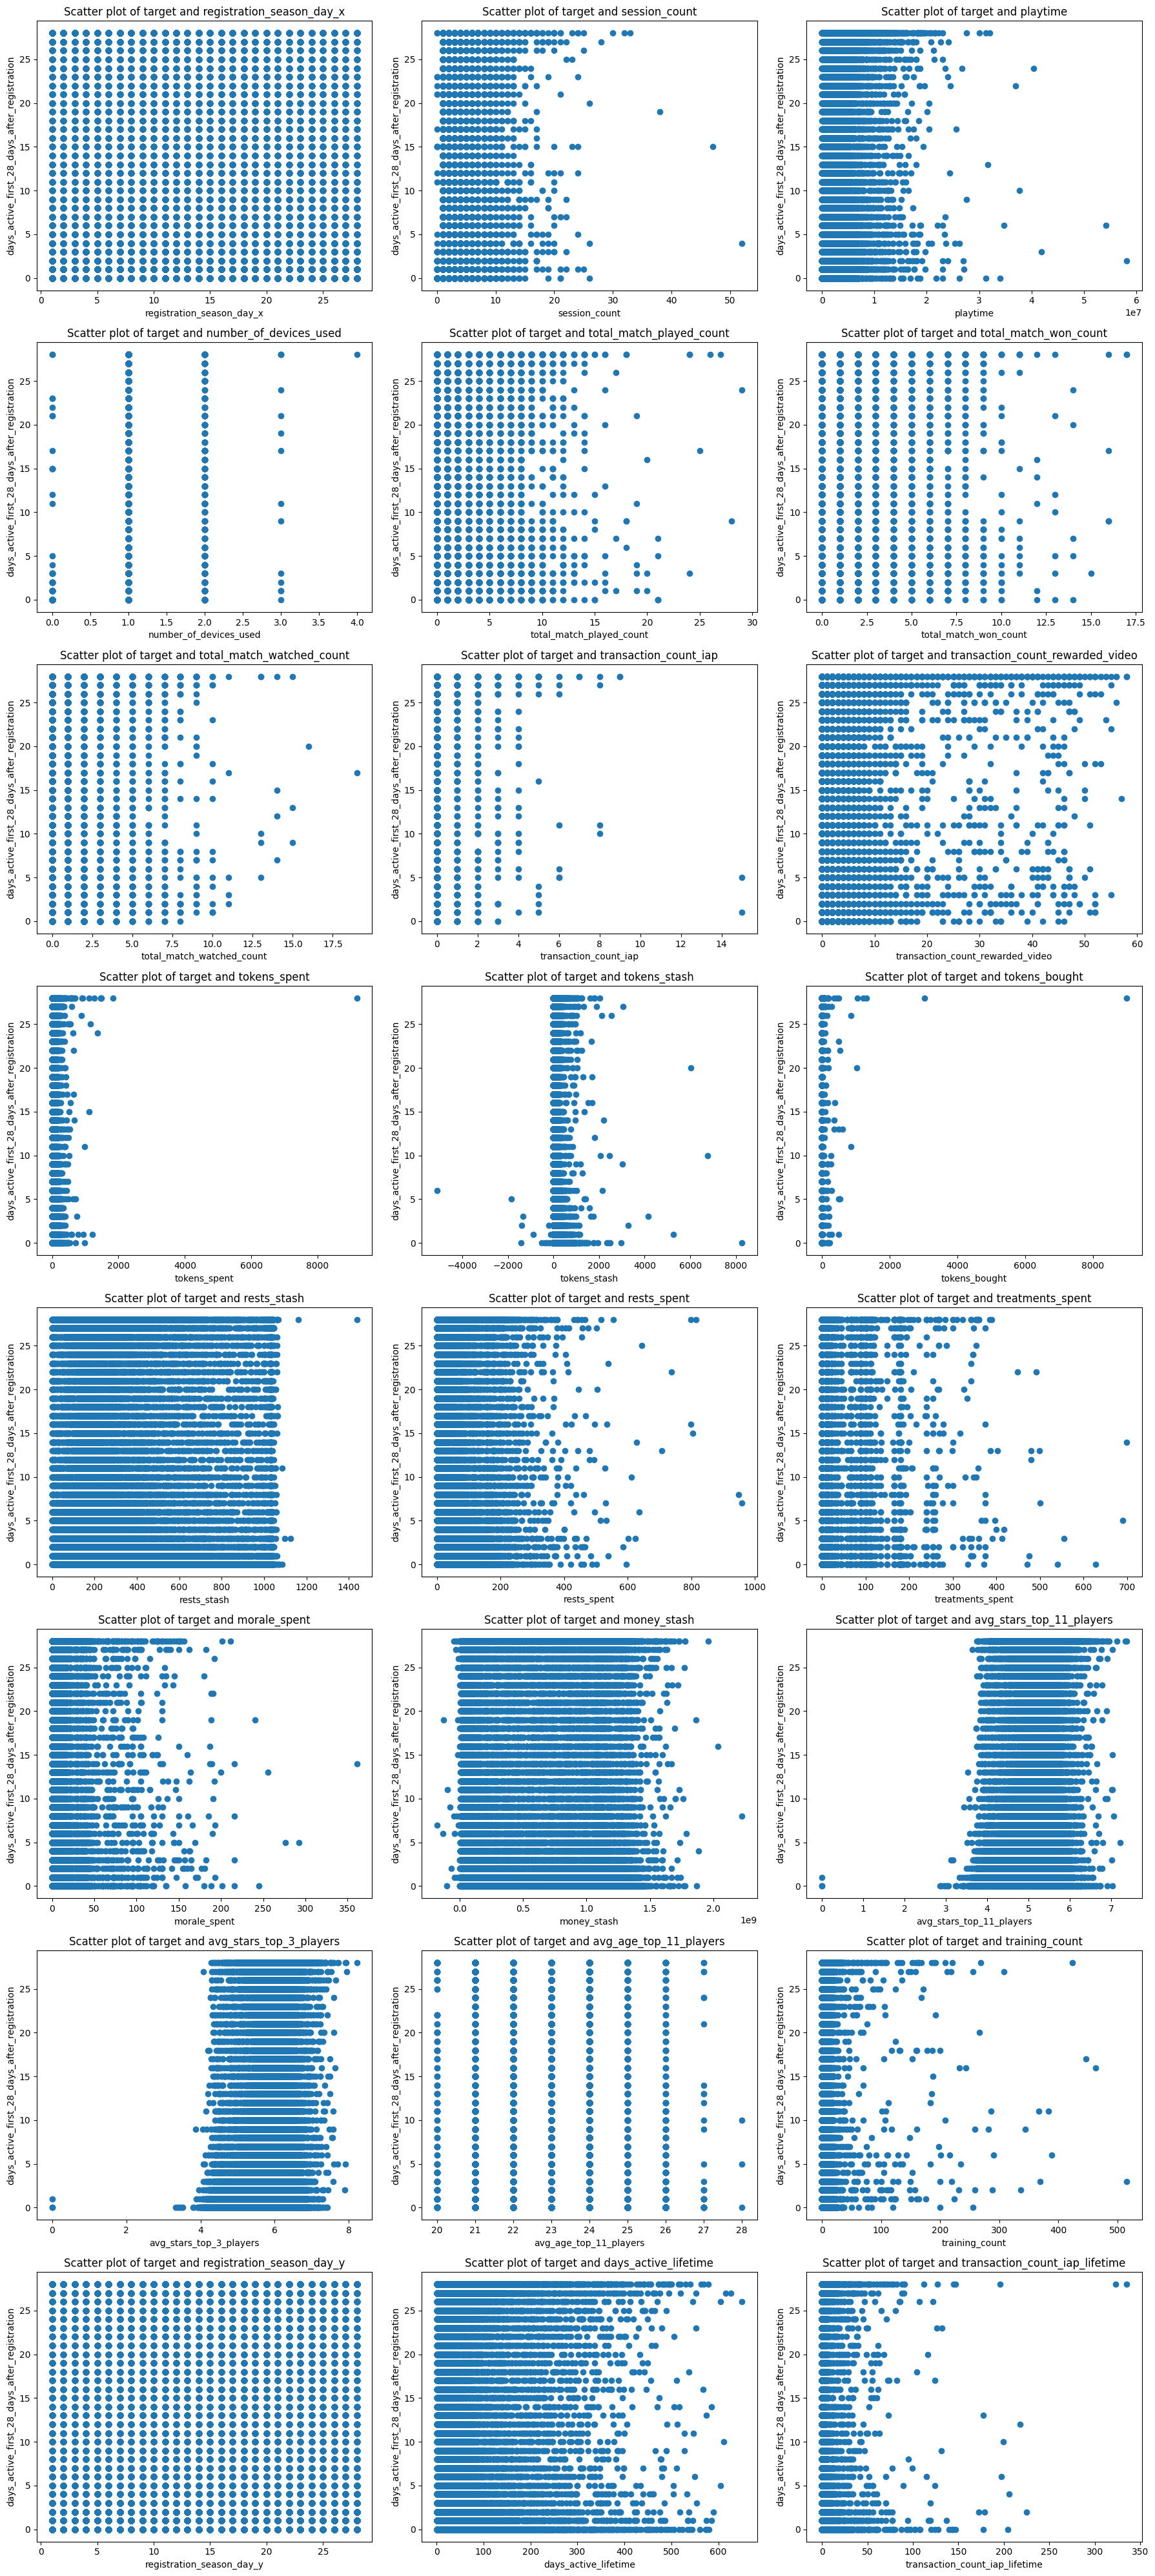

In [21]:
# Definiši ciljnu promenljivu
target = 'days_active_first_28_days_after_registration'

# Izbaci ciljnu promenljivu i 'user_id' iz numeričkih kolona
numerical_features = [col for col in numerical_features if col != target and col != 'user_id']
# print('Numerical features without target:', numerical_features)

# Broj kolona po redu
num_cols = 3

# Izračunavanje broja redova potrebnih da se prikažu svi grafovi
num_plots = len(numerical_features)
num_rows = (num_plots + num_cols - 1) // num_cols

# Kreiraj figure i podgrafikone (subplots)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, num_rows * 5))

# Poravnaj ose za jednostavnost kada ima manje grafova nego podgrafikona
axes = axes.flatten()

# Prolazi kroz sve numeričke kolone i pravi scatter plot
for i, col in enumerate(numerical_features):
    if col != target:  # Ne pravi scatter plot ako je kolona ciljana promenljiva
        axes[i].scatter(x=df_train[col], y=df_train[target])
        axes[i].set_xlabel(col)
        axes[i].set_ylabel(target)
        axes[i].set_title(f'Scatter plot of target and {col}')

# Ukoliko ima više podgrafikona nego numeričkih kolona, sakri prazne podgrafikone
for i in range(num_plots, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [22]:
# Data cleaning

# Kombinacija svih upita u jednu masku
outlier_mask = (
    (df_train['session_count'] > 35) |
    (df_train['playtime'] > 4 * 1e7) |
    (df_train['total_match_played_count'] > 23) |
    (df_train['total_match_won_count'] > 14) |
    (df_train['total_match_watched_count'] > 14) |
    (df_train['transaction_count_iap'] > 10) |
    (df_train['transaction_count_rewarded_video'] > 55) |
    (df_train['tokens_spent'] > 3000) |
    (df_train['tokens_stash'] < 0) |
    (df_train['tokens_stash'] > 4000) |
    (df_train['tokens_bought'] > 3000) |
    (df_train['rests_stash'] > 1100) |
    (df_train['rests_spent'] > 600) |
    (df_train['treatments_spent'] > 500) |
    (df_train['morale_spent'] > 250) |
    (df_train['money_stash'] < 0) |
    (df_train['money_stash'] > 2*1e9) |
    (df_train['avg_stars_top_11_players'] < 0) |
    (df_train['avg_stars_top_11_players'] > 7) |
    (df_train['avg_stars_top_3_players'] < 0) |
    (df_train['avg_stars_top_3_players'] > 7) |
    (df_train['training_count'] > 350) |
    (df_train['days_active_lifetime'] > 500) |
    (df_train['transaction_count_iap_lifetime'] > 170)
)

# Uklanjanje redova koji odgovaraju maski
df_train = df_train[~outlier_mask]

# Ispis rezultata
print(f"Broj redova pre uklanjanja outliera: {len(df_train)}")
print(f"Broj redova posle uklanjanja outliera: {len(df_train)}")

# Izbaci kolone koje nisu potrebne
df_train = df_train.drop(columns=['registration_season_day_x', 'registration_season_day_y', 'number_of_devices_used', 'avg_age_top_11_players'])

# Numerički features za df_rain_cleaned
numerical_features= df_train.select_dtypes(include=['int64', 'float64']).columns
print('Numerical features :', list(numerical_features))

Broj redova pre uklanjanja outliera: 49582
Broj redova posle uklanjanja outliera: 49582
Numerical features : ['user_id', 'session_count', 'playtime', 'total_match_played_count', 'total_match_won_count', 'total_match_watched_count', 'transaction_count_iap', 'transaction_count_rewarded_video', 'tokens_spent', 'tokens_stash', 'tokens_bought', 'rests_stash', 'rests_spent', 'treatments_spent', 'morale_spent', 'money_stash', 'avg_stars_top_11_players', 'avg_stars_top_3_players', 'training_count', 'days_active_first_28_days_after_registration', 'days_active_lifetime', 'transaction_count_iap_lifetime']


In [23]:
# import pandas as pd
# import numpy as np
# from scipy.stats import zscore

# # Funkcija za proveru Z-score distribucije
# def check_zscore_distribution(df, column):
#     z_scores = zscore(df[column])
#     print(f"Z-score distribucija za '{column}':")
#     print(pd.Series(z_scores).describe())
#     return z_scores

# for column in numerical_features_without_target:
#         print(f"\nProvera kolone: {column}")
        
#         # Poziv funkcije check_zscore_distribution za trenutnu kolonu
#         z_scores = check_zscore_distribution(df_train, column)

# Prag za Z-score
# thresholds = {
#     'registration_season_day_x': 3,
#     'session_count': 5,
#     'playtime': 5,
#     'number_of_devices_used': 5,
#     'total_match_played_count': 4,
#     'total_match_won_count': 5,
#     'total_match_watched_count': 5,
#     'transaction_count_iap': 10,
#     'transaction_count_rewarded_video': 5,
#     'tokens_spent': 7,
#     'tokens_stash': 10
# }

# # Funkcija za uklanjanje outliera pomoću Z-score
# def remove_outliers_custom_thresholds(df, thresholds):
#     df_filtered = df.copy()
#     for column, threshold in thresholds.items():
#         if column in df_filtered.columns:
#             z_scores = zscore(df_filtered[column])
#             df_filtered = df_filtered[np.abs(z_scores) <= threshold]
#     return df_filtered

# df_cleaned = remove_outliers_custom_thresholds(df_train, thresholds)


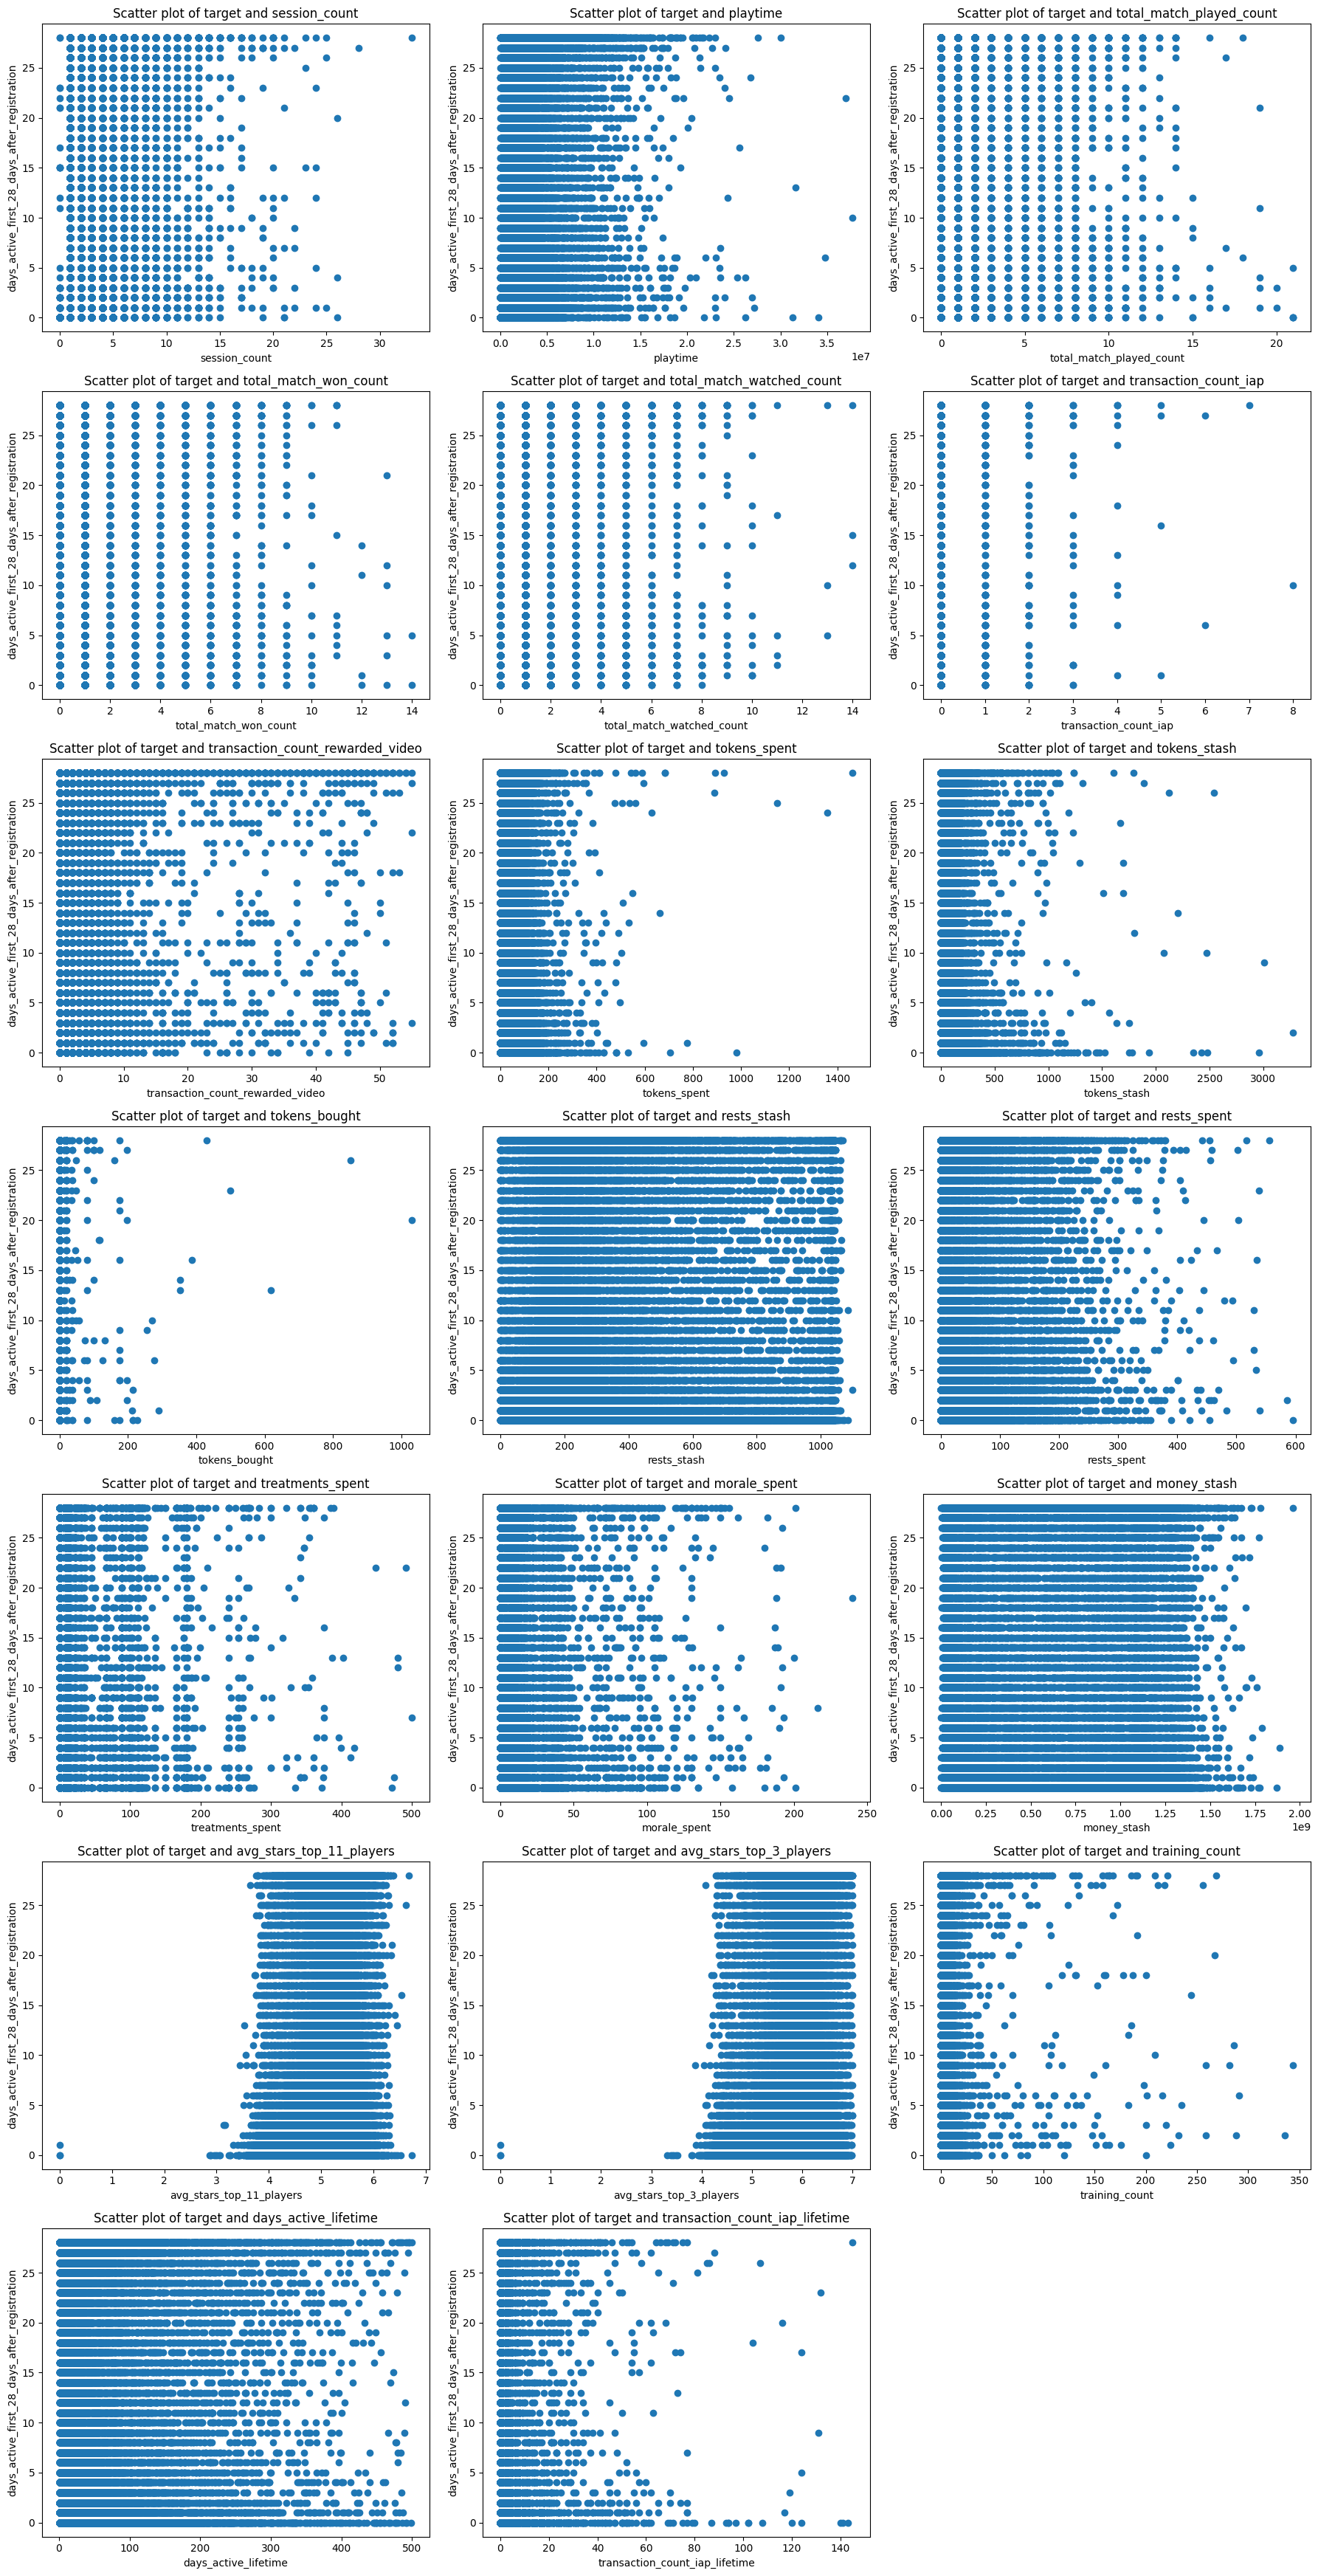

In [24]:
# Definiši ciljnu promenljivu
target = 'days_active_first_28_days_after_registration'

numerical_features = [col for col in df_train.select_dtypes(include=['int64', 'float64']).columns if col != target and col != 'user_id']

# Broj kolona po redu
num_cols = 3

# Izračunavanje broja redova potrebnih da se prikažu svi grafovi
num_plots = len(numerical_features)
num_rows = (num_plots + num_cols - 1) // num_cols

# Kreiraj figure i podgrafikone (subplots)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, num_rows * 5))

# Poravnaj ose za jednostavnost kada ima manje grafova nego podgrafikona
axes = axes.flatten()

# Prolazi kroz sve numeričke kolone i pravi scatter plot
for i, col in enumerate(numerical_features):
    if col != target:  # Ne pravi scatter plot ako je kolona ciljana promenljiva
        axes[i].scatter(x=df_train[col], y=df_train[target])
        axes[i].set_xlabel(col)
        axes[i].set_ylabel(target)
        axes[i].set_title(f'Scatter plot of target and {col}')

# Ukoliko ima više podgrafikona nego numeričkih kolona, sakrij prazne podgrafikone
for i in range(num_plots, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [25]:
# Dodavanje novih numerickih feature-a

# 1. 'days_since_registration' - Broj dana od pretposlednje registracije do poslednje registracije
df_train['registration_time_utc'] = pd.to_datetime(df_train['registration_time_utc'])
df_train['registration_date'] = pd.to_datetime(df_train['registration_date'])

df_train['days_since_registration'] = (df_train['registration_date'] - df_train['registration_time_utc']).dt.days
df_train = df_train.drop(columns=['registration_time_utc', 'registration_date'])

df_test['registration_time_utc'] = pd.to_datetime(df_test['registration_time_utc'])
df_test['registration_date'] = pd.to_datetime(df_test['registration_date'])

df_test['days_since_registration'] = (df_test['registration_date'] - df_test['registration_time_utc']).dt.days
df_test = df_test.drop(columns=['registration_time_utc', 'registration_date'])

# 2. 'win_ratio' - Odnos između ukupnog broja pobeda i ukupnog broja odigranih mečeva
df_train['win_ratio'] = df_train['total_match_won_count'] / df_train['total_match_played_count'].replace(0, 1)
df_train = df_train.drop(columns=['total_match_won_count'])

df_test['win_ratio'] = df_test['total_match_won_count'] / df_test['total_match_played_count'].replace(0, 1)
df_test = df_test.drop(columns=['total_match_won_count'])

# 3. 'platform_interaction' - Kombinacija različitih platformi koje je korisnik koristio
# df_train['platform_interaction'] = df_train['registration_platform_specific_x'] + '_' + df_train['registration_platform_specific_y']
# df_train = df_train.drop(columns=['registration_platform_specific_x', 'registration_platform_specific_y'])

# df_test['platform_interaction'] = df_test['registration_platform_specific_x'] + '_' + df_test['registration_platform_specific_y']
# df_test = df_test.drop(columns=['registration_platform_specific_x', 'registration_platform_specific_y'])

# 4. 'watch_to_play_ratio' - Odnos između broja gledanih i odigranih mečeva
df_train['watch_to_play_ratio'] = df_train['total_match_watched_count'] / df_train['total_match_played_count'].replace(0, 1)
df_train = df_train.drop(columns=['total_match_watched_count', 'total_match_played_count'])

df_test['watch_to_play_ratio'] = df_test['total_match_watched_count'] / df_test['total_match_played_count'].replace(0, 1)
df_test = df_test.drop(columns=['total_match_watched_count', 'total_match_played_count'])

# 5. 'iap_per_session' - Prosečan broj transakcija po sesiji (in-app purchase)
df_train['iap_per_session'] = df_train['transaction_count_iap'] / df_train['session_count'].replace(0, 1)
df_train = df_train.drop(columns=['transaction_count_iap'])

df_test['iap_per_session'] = df_test['transaction_count_iap'] / df_test['session_count'].replace(0, 1)
df_test = df_test.drop(columns=['transaction_count_iap'])

# 6. 'total_tokens' - Ukupan broj tokena (kupljenih i ušteđenih)
df_train['total_tokens'] = df_train['tokens_spent'] + df_train['tokens_stash'] + df_train['tokens_bought']
df_train = df_train.drop(columns=['tokens_spent', 'tokens_stash', 'tokens_bought'])

df_test['total_tokens'] = df_test['tokens_spent'] + df_test['tokens_stash'] + df_test['tokens_bought']
df_test = df_test.drop(columns=['tokens_spent', 'tokens_stash', 'tokens_bought'])

# 7. 'total_resources_spent' - Ukupan broj potrošenih resursa
df_train['total_resources_spent'] = df_train['rests_spent'] + df_train['treatments_spent'] + df_train['morale_spent']
df_train = df_train.drop(columns=['rests_spent', 'treatments_spent', 'morale_spent'])

df_test['total_resources_spent'] = df_test['rests_spent'] + df_test['treatments_spent'] + df_test['morale_spent']
df_test = df_test.drop(columns=['rests_spent', 'treatments_spent', 'morale_spent'])


In [26]:
# Numerički features za df_train
numerical_features_new = df_train.select_dtypes(include=['int64', 'float64']).columns
print('Numerical features:', list(numerical_features_new))

Numerical features: ['user_id', 'session_count', 'playtime', 'transaction_count_rewarded_video', 'rests_stash', 'money_stash', 'avg_stars_top_11_players', 'avg_stars_top_3_players', 'training_count', 'days_active_first_28_days_after_registration', 'days_active_lifetime', 'transaction_count_iap_lifetime', 'days_since_registration', 'win_ratio', 'watch_to_play_ratio', 'iap_per_session', 'total_tokens', 'total_resources_spent']


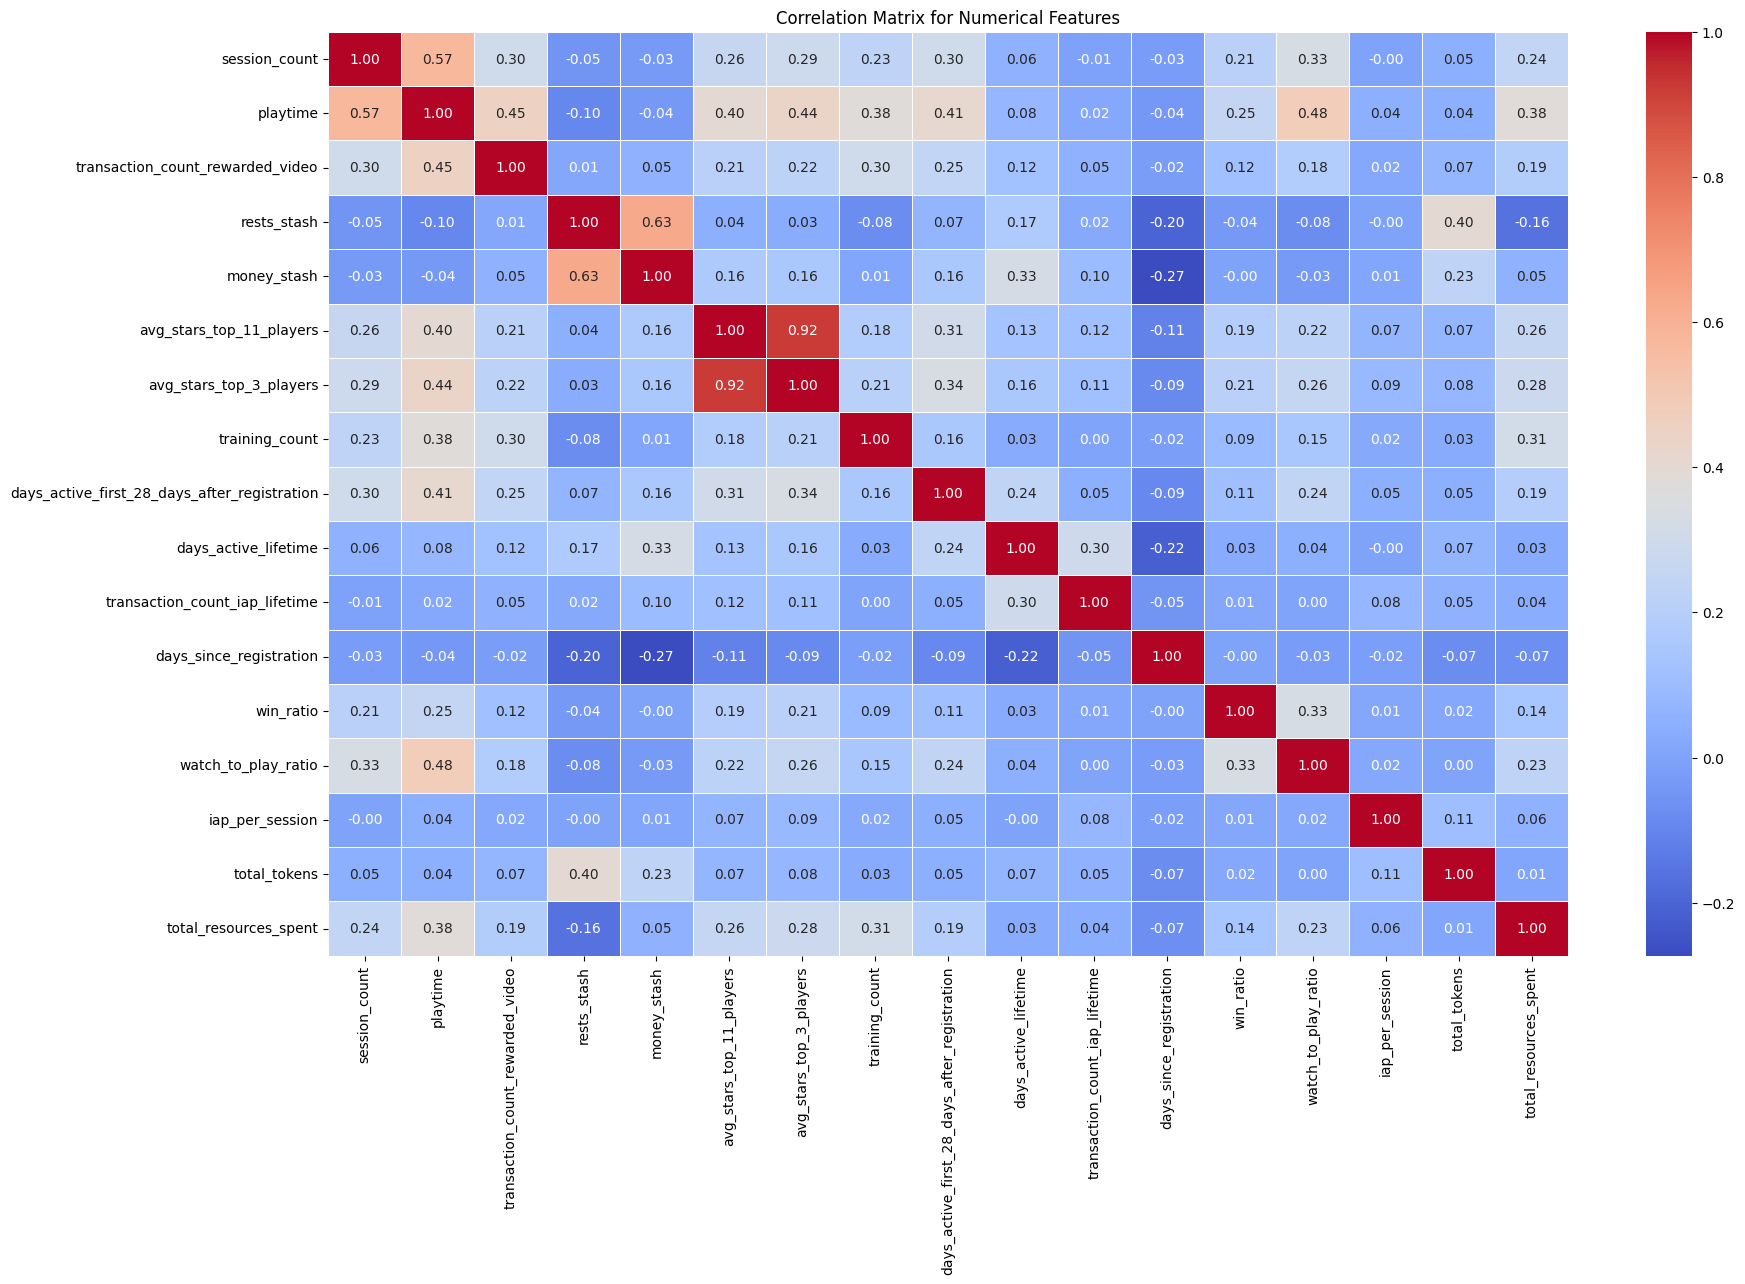

In [27]:
# Kreiraj korelacionu matricu
numerical_features_new= [col for col in numerical_features_new if col != 'user_id']    
df_numerical = df_train[numerical_features_new]
correlation_matrix = df_numerical.corr()

# Prikaz korelacione matrice koristeći seaborn
plt.figure(figsize=(20, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title('Correlation Matrix for Numerical Features')
plt.show()

In [28]:
df_train = df_train.drop(columns=['days_active_lifetime', 'transaction_count_iap_lifetime', 'rests_stash', 'money_stash', 'transaction_count_iap_lifetime', 'days_since_registration', 'training_count'])
df_test = df_test.drop(columns=['days_active_lifetime', 'transaction_count_iap_lifetime', 'rests_stash', 'money_stash', 'transaction_count_iap_lifetime', 'days_since_registration', 'training_count'])

# Numerički features za df_rain_cleaned
numerical_features = df_train.select_dtypes(include=['int64', 'float64']).columns
print('Numerical features:', list(numerical_features))

Numerical features: ['user_id', 'session_count', 'playtime', 'transaction_count_rewarded_video', 'avg_stars_top_11_players', 'avg_stars_top_3_players', 'days_active_first_28_days_after_registration', 'win_ratio', 'watch_to_play_ratio', 'iap_per_session', 'total_tokens', 'total_resources_spent']


In [29]:
# Funkcija za primenu na par `x` i `y` kolona
def generate_features_for_pairs(df, column_x, column_y):

    # 1. Loyal ili Switching korisnik
    loyal_col_name = f'loyal_{column_x}_{column_y}'
    df[loyal_col_name] = df[column_x] == df[column_y]
    df[loyal_col_name] = df[loyal_col_name].map({True: "Loyal", False: "Switching"})

    return df

# Liste kolona za obradu
column_pairs = [
    ('registration_country_x', 'registration_country_y'),
    ('registration_platform_specific_x', 'registration_platform_specific_y'),
    ('registration_store_x', 'registration_store_y'),
    ('registration_channel_detailed_x', 'registration_channel_detailed_y')
]

# Target kolona
target_col = 'days_active_first_28_days_after_registration'

# Primena funkcije za sve parove kolona
for col_x, col_y in column_pairs:
    df_train = generate_features_for_pairs(df_train, col_x, col_y)
    df_test = generate_features_for_pairs(df_test, col_x, col_y)

# Izbaci kolone koje su korišćene za generisanje novih feature-a
df_train = df_train.drop(columns=[col for col in df_train.columns if col.endswith('_x')])
df_train = df_train.drop(columns=[col for col in df_train.columns if col.endswith('_x')])

# Kategorijski features za df_test
categorical_features = df_train.select_dtypes(include=['object']).columns
print('Categorical features:', list(categorical_features))

Categorical features: ['registration_device_type', 'registration_device_manufacturer', 'registration_country_y', 'registration_channel_detailed_y', 'registration_store_y', 'registration_platform_specific_y', 'loyal_registration_country_x_registration_country_y', 'loyal_registration_platform_specific_x_registration_platform_specific_y', 'loyal_registration_store_x_registration_store_y', 'loyal_registration_channel_detailed_x_registration_channel_detailed_y']


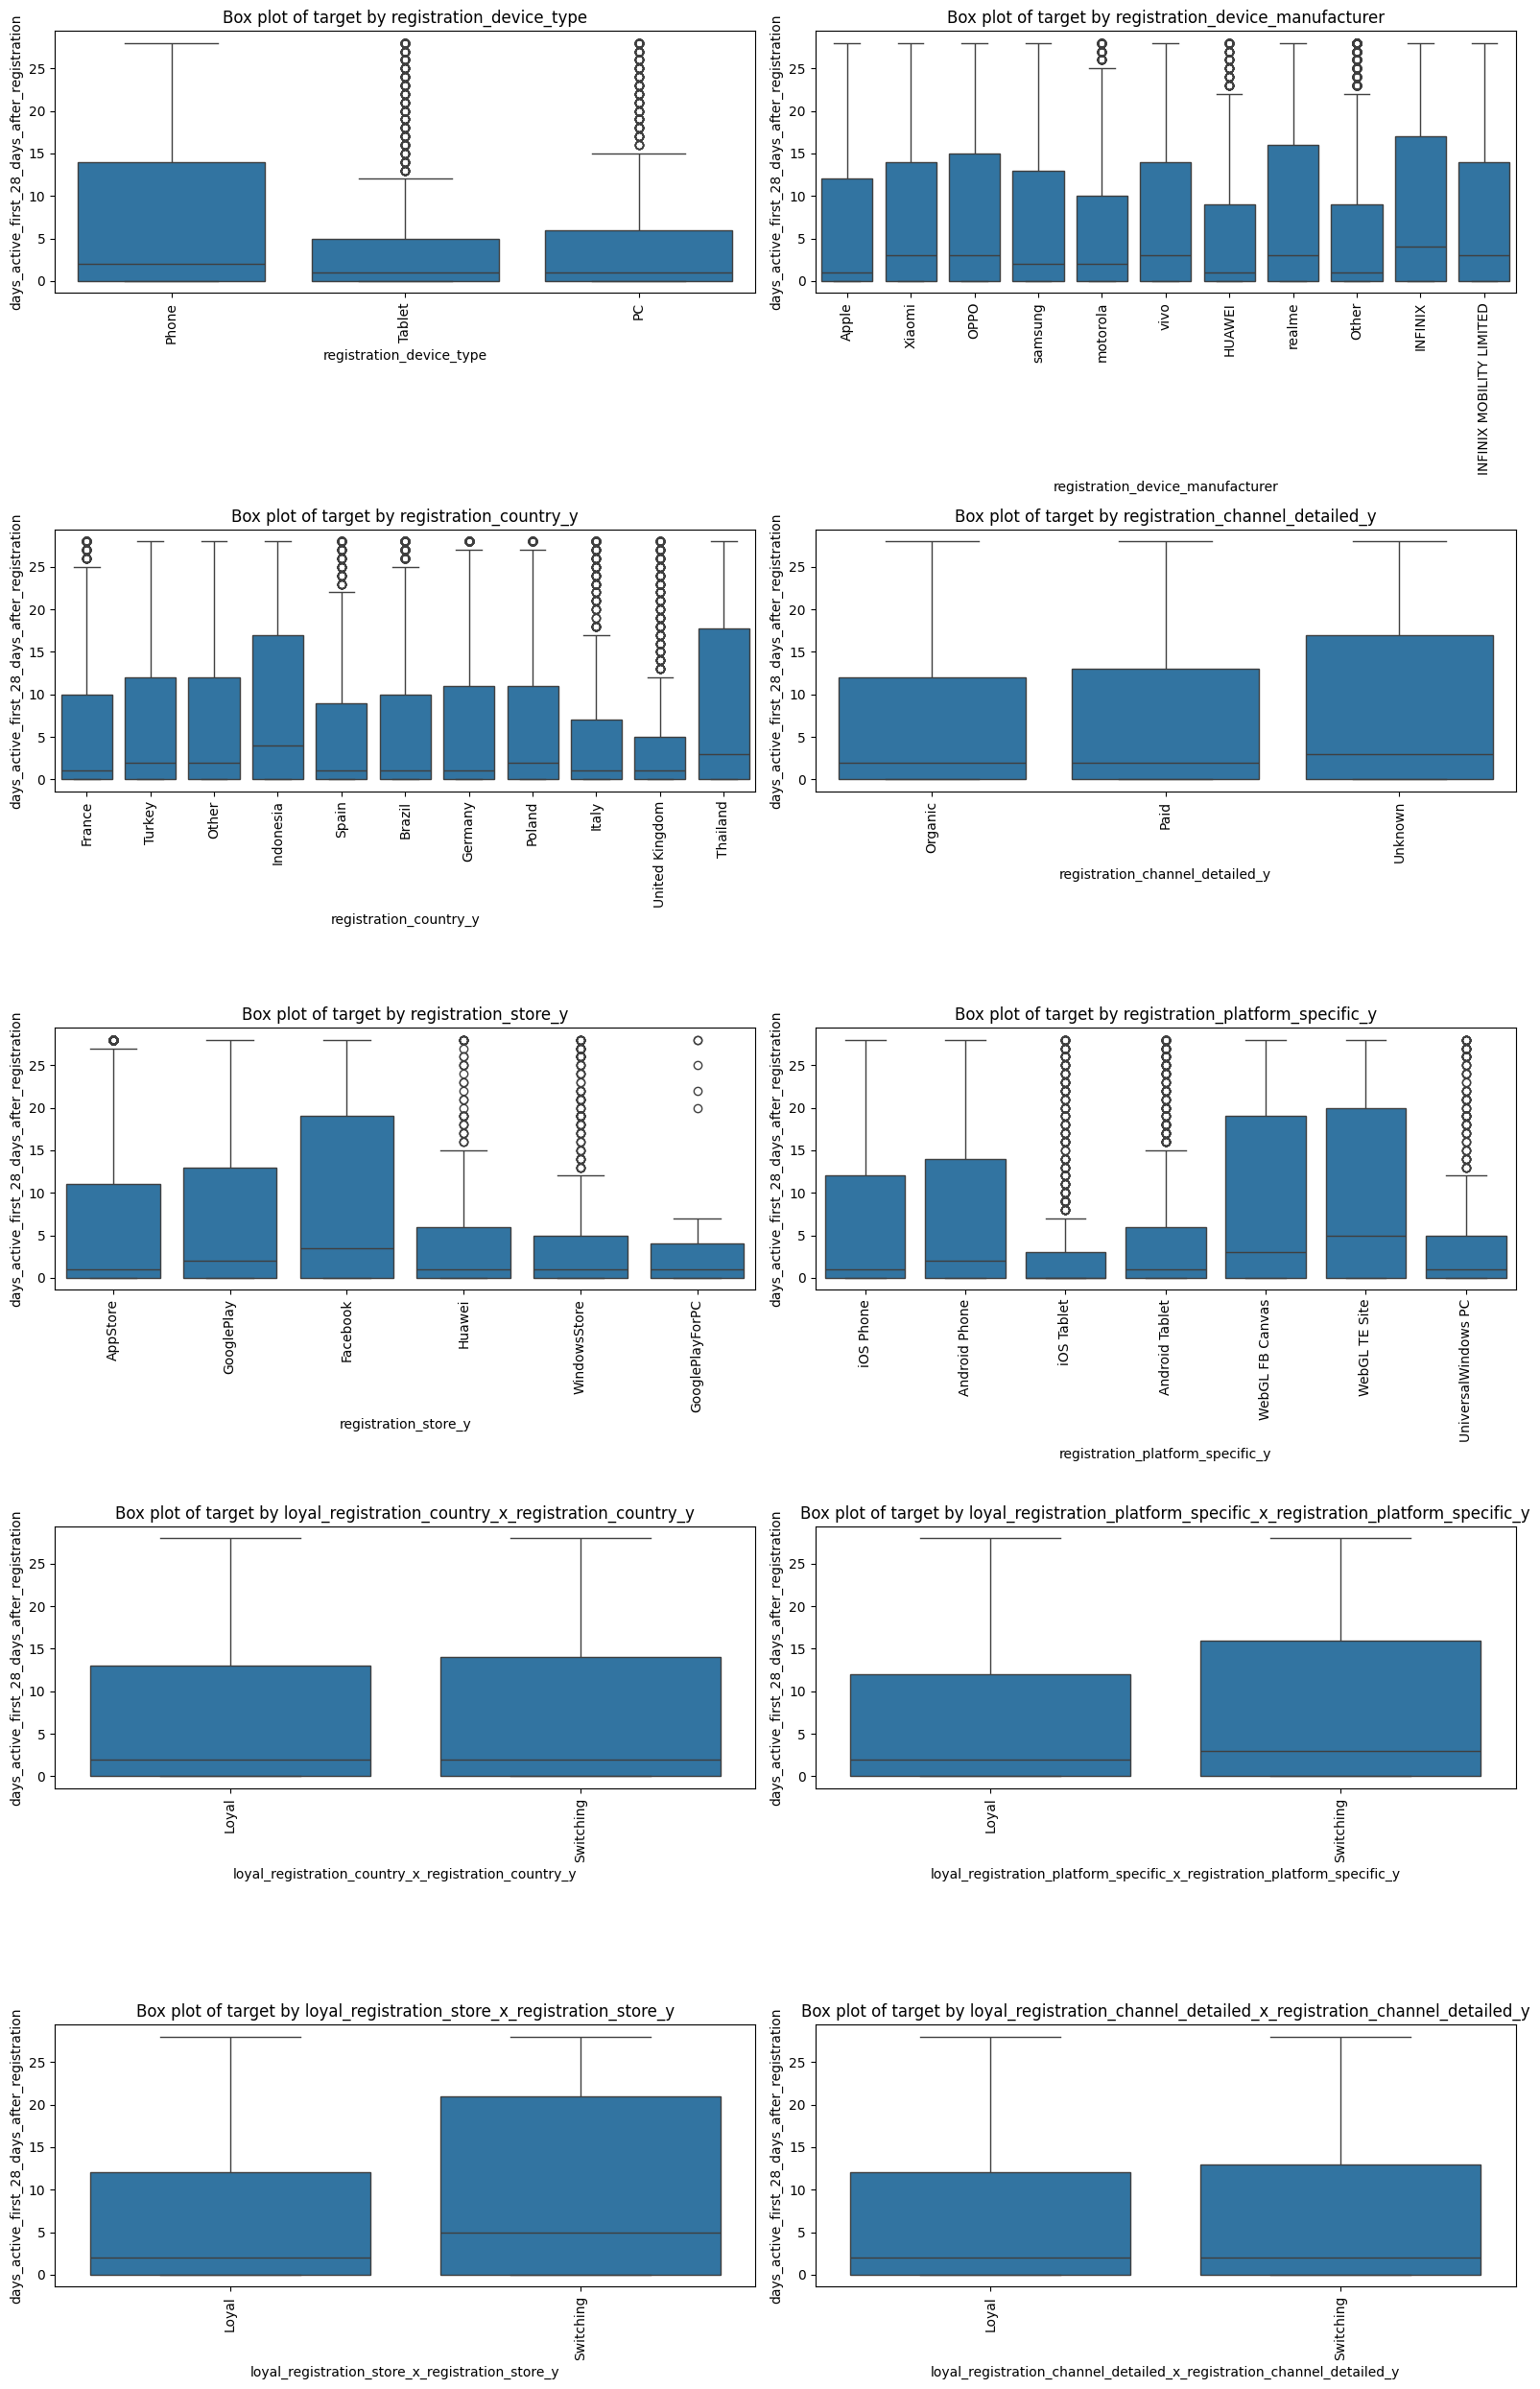

In [30]:
# Ciljana promenljiva
target = 'days_active_first_28_days_after_registration'

# Grupisanje retkih vrednosti za 'registration_country' i 'registration_device_manufacturer'
# Zadržati samo prvih 10 najčešćih vrednosti, ostale grupisati kao 'Other'
for col in ['registration_country_y', 'registration_device_manufacturer']:
    top_values = df_train[col].value_counts().nlargest(10).index
    df_train[col] = df_train[col].apply(lambda x: x if x in top_values else 'Other')

# Broj kolona po redu
num_cols = 2

# Izračunavanje broja redova potrebnih da se prikažu svi grafici
num_plots = len(categorical_features)
num_rows = (num_plots + num_cols - 1) // num_cols

# Kreiraj figure i podgrafikone (subplots)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, num_rows * 5))

# Poravnaj ose za jednostavnost kada ima manje grafika nego podgrafikona
axes = axes.flatten()

# Prolazimo kroz sve kategorijske kolone i pravimo boxplot
for i, col in enumerate(categorical_features):
    sns.boxplot(data=df_train, x=col, y=target, ax=axes[i])
    axes[i].set_title(f'Box plot of target by {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel(target)
    axes[i].tick_params(axis='x', rotation=90)

# Ukoliko ima više podgrafikona nego kategorijskih kolona, sakrij prazne podgrafikone
for i in range(num_plots, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

<Axes: xlabel='days_active_first_28_days_after_registration', ylabel='Count'>

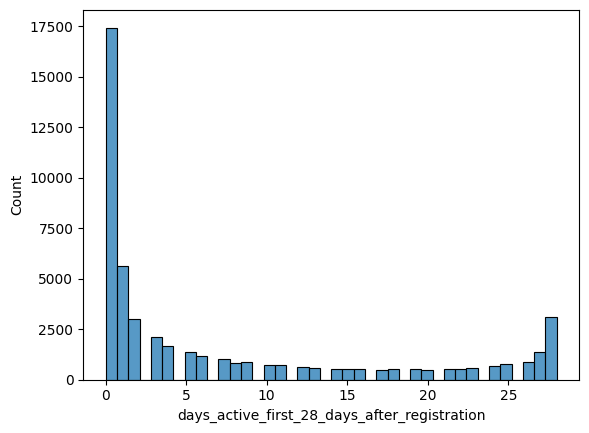

In [31]:
# Prikaz novog histograma
sns.histplot(
    df_train,
    x=df_train['days_active_first_28_days_after_registration'],
)

In [32]:
df_train['days_active_first_28_days_after_registration'] = np.log1p(df_train['days_active_first_28_days_after_registration'])

<Axes: xlabel='days_active_first_28_days_after_registration', ylabel='Count'>

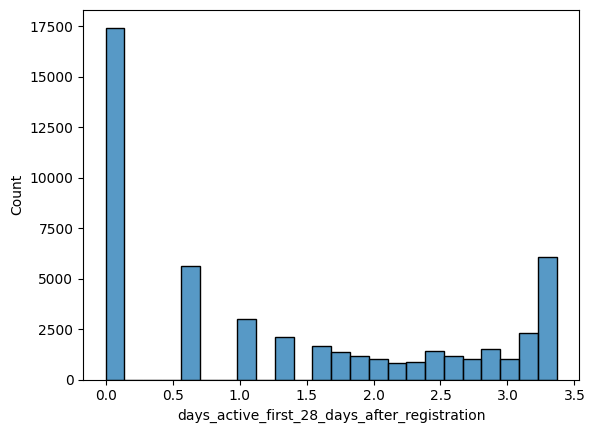

In [33]:
# Prikaz novog histograma
sns.histplot(
    df_train,
    x=df_train['days_active_first_28_days_after_registration'],
)

In [34]:
# Numeričke kolone
num_cols = df_train.select_dtypes(include=['int64', 'float64']).columns
print('Numerical columns:', list(num_cols))
num_cols = num_cols.drop(target)

# Kategorijske kolone
cat_cols = df_train.select_dtypes(include=['object']).columns
print('Categorical columns:', list(cat_cols))

# Odabir kolona za Ordinal i One-Hot kodiranje
# Za kategorije sa jasnim redosledom koristićemo OrdinalEncoder 
# Za kategorije bez jasnog redosleda koristićemo OneHotEncoder 

ohe_cols = [
    'registration_device_manufacturer',
    'registration_device_type',
    'registration_country_y',
    'registration_store_y',
    'registration_platform_specific_y',
    'loyal_registration_country_x_registration_country_y',
    'loyal_registration_platform_specific_x_registration_platform_specific_y',
    'loyal_registration_store_x_registration_store_y',
    'loyal_registration_channel_detailed_x_registration_channel_detailed_y'
]

ode_cols = [
    'registration_channel_detailed_y'
]

# Kreiranje pipeline-ova za numeričke i kategorijske kolone
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

ode_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

ohe_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Kreiranje ColumnTransformer-a
col_trans = ColumnTransformer(transformers=[
    ('num_p', num_pipeline, num_cols),
    ('ode_p', ode_pipeline, ode_cols),
    ('ohe_p', ohe_pipeline, ohe_cols),
    ],
    remainder='passthrough', 
    n_jobs=-1)

# Glavni pipeline
pipeline = Pipeline(steps=[
    ('preprocessing', col_trans)
])

Numerical columns: ['user_id', 'session_count', 'playtime', 'transaction_count_rewarded_video', 'avg_stars_top_11_players', 'avg_stars_top_3_players', 'days_active_first_28_days_after_registration', 'win_ratio', 'watch_to_play_ratio', 'iap_per_session', 'total_tokens', 'total_resources_spent']
Categorical columns: ['registration_device_type', 'registration_device_manufacturer', 'registration_country_y', 'registration_channel_detailed_y', 'registration_store_y', 'registration_platform_specific_y', 'loyal_registration_country_x_registration_country_y', 'loyal_registration_platform_specific_x_registration_platform_specific_y', 'loyal_registration_store_x_registration_store_y', 'loyal_registration_channel_detailed_x_registration_channel_detailed_y']


In [35]:
# Definisanje ciljne promenljive i ulaznih promenljivih
X_train = df_train.drop('days_active_first_28_days_after_registration',  axis=1)
y_train = df_train['days_active_first_28_days_after_registration']

In [36]:
X_preprocessed = pipeline.fit_transform(X_train)

In [37]:
# Podela trening podataka na trening i validacioni skup
X_train, X_valid, y_train, y_valid = train_test_split(X_preprocessed, y_train, test_size=0.2, random_state=42)

In [38]:
# XGBRegressor
XGB = XGBRegressor(random_state=42)

# Parametri za pretragu
param_grid_XGB = {
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [300],
    'max_depth': [3],
    'min_child_weight': [1,2,3],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

# GridSearchCV
xgb_cv = GridSearchCV(XGB, param_grid_XGB, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

# Fitovanje modela
xgb_cv.fit(X_train, y_train)


#np.sqrt(-1 * xgb_cv.best_score_)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'gamma': [0, 0.1, 0.2],
                         'learning_rate': [0.05, 0.1, 0.2], 'max_depth': [3],
                         'min_child_weight': [1, 2, 3], 'n_estimators': [300],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='neg_mean_squared_error')

In [39]:
# Koristi najbolje parametre za predikciju na validacionom skupu
best_xgb = xgb_cv.best_estimator_

# Predikcija na validacionom skupu
y_valid_pred = best_xgb.predict(X_valid)

# Izračunaj MAE na validacionom skupu
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_valid, y_valid_pred)
print(f"Mean Absolute Error (MAE) na validacionom skupu: {mae}")

X_test_preprocessed = pipeline.transform(df_test) 

# Predikcija na test skupu
y_test_pred = best_xgb.predict(X_test_preprocessed)
y_test_pred = np.clip(y_test_pred, 0, 28).astype(int)

# Cuvanje rezultata sa selektovanim karakteristikama u zadatom formatu
submission_selected_df = pd.DataFrame({'user_id': df_test['user_id'], 'predicted_days_active_first_28_days_after_registration': y_test_pred})
submission_selected_df.to_csv('days_active_first_28_days_after_registration_predictions_selected_features_xgb.csv', index=False)

Mean Absolute Error (MAE) na validacionom skupu: 0.8095966655478802


In [40]:
# RFR = RandomForestRegressor(random_state=13)
# param_grid_RFR = {
#     'max_depth': [5, 10, 15],
#     'n_estimators': [100, 250, 500],
#     'min_samples_split': [3, 5, 10]
# }
# rfr_cv = GridSearchCV(RFR, param_grid_RFR, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
# rfr_cv.fit(X_train, y_train)

# #np.sqrt(-1 * rfr_cv.best_score_)

# rfr_cv.best_params_

In [41]:
# # Koristi najbolje parametre za predikciju na validacionom skupu
# best_rfr = rfr_cv.best_params_

# # Predikcija na validacionom skupu
# y_valid_pred = best_rfr.predict(X_valid)

# # Izračunaj MAE na validacionom skupu
# from sklearn.metrics import mean_absolute_error
# mae = mean_absolute_error(y_valid, y_valid_pred)
# print(f"Mean Absolute Error (MAE) na validacionom skupu: {mae}")

# X_test_preprocessed = pipeline.transform(df_test) 

# # Predikcija na test skupu
# y_test_pred = best_rfr.predict(X_test_preprocessed)
# y_test_pred = np.clip(y_test_pred, 0, 28).astype(int)

# # Cuvanje rezultata sa selektovanim karakteristikama u zadatom formatu
# submission_selected_df = pd.DataFrame({'user_id': df_test['user_id'], 'predicted_days_active_first_28_days_after_registration': y_test_pred})
# submission_selected_df.to_csv('days_active_first_28_days_after_registration_predictions_selected_features_rfr.csv', index=False)

In [42]:
from sklearn.linear_model import Ridge
ridge = Ridge()
param_grid_ridge = {
    'alpha': [0.05, 0.1, 1, 3, 5, 10],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag']
}
ridge_cv = GridSearchCV(ridge, param_grid_ridge, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
ridge_cv.fit(X_train, y_train)
#np.sqrt(-1 * ridge_cv.best_score_)

GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.05, 0.1, 1, 3, 5, 10],
                         'solver': ['auto', 'svd', 'cholesky', 'lsqr',
                                    'sparse_cg', 'sag']},
             scoring='neg_mean_squared_error')

In [44]:
# Koristi najbolje parametre za predikciju na validacionom skupu
best_ridge = ridge_cv.best_estimator_

# Predikcija na validacionom skupu
y_valid_pred = best_ridge.predict(X_valid)

# Izračunaj MAE na validacionom skupu
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_valid, y_valid_pred)
print(f"Mean Absolute Error (MAE) na validacionom skupu: {mae}")

X_test_preprocessed = pipeline.transform(df_test) 

# Predikcija na test skupu
y_test_pred = best_ridge.predict(X_test_preprocessed)
y_test_pred = np.clip(y_test_pred, 0, 28).astype(int)

# Cuvanje rezultata sa selektovanim karakteristikama u zadatom formatu
submission_selected_df = pd.DataFrame({'user_id': df_test['user_id'], 'predicted_days_active_first_28_days_after_registration': y_test_pred})
submission_selected_df.to_csv('days_active_first_28_days_after_registration_predictions_selected_features_ridge.csv', index=False)

Mean Absolute Error (MAE) na validacionom skupu: 0.9034502353079198


In [1]:
# GBR = GradientBoostingRegressor()
# param_grid_GBR = {
#     'max_depth': [12, 15, 20],
#     'n_estimators': [200, 300, 1000],
#     'min_samples_leaf': [10, 25, 50],
#     'learning_rate': [0.001, 0.01, 0.1],
#     'max_features': [0.01, 0.1, 0.7]
# }
# GBR_cv = GridSearchCV(GBR, param_grid_GBR, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
# GBR_cv.fit(X_train, y_train)

# # np.sqrt(-1 * GBR_cv.best_score_)

In [ ]:
# # Koristi najbolje parametre za predikciju na validacionom skupu
# best_gbr = GBR_cv.best_estimator_

# # Predikcija na validacionom skupu
# y_valid_pred = best_gbr.predict(X_valid)

# # Izračunaj MAE na validacionom skupu
# from sklearn.metrics import mean_absolute_error
# mae = mean_absolute_error(y_valid, y_valid_pred)
# print(f"Mean Absolute Error (MAE) na validacionom skupu: {mae}")

# X_test_preprocessed = pipeline.transform(df_test) 

# # Predikcija na test skupu
# y_test_pred = best_gbr.predict(X_test_preprocessed)
# y_test_pred = np.clip(y_test_pred, 0, 28).astype(int)

# # Cuvanje rezultata sa selektovanim karakteristikama u zadatom formatu
# submission_selected_df = pd.DataFrame({'user_id': df_test['user_id'], 'predicted_days_active_first_28_days_after_registration': y_test_pred})
# submission_selected_df.to_csv('days_active_first_28_days_after_registration_predictions_selected_features_gbr.csv', index=False)